In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


## Dynamic Time Warping

https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html

In [2]:
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path, filename="img/warp.png")

(None, None)

<img src="img/warp.png">

### Measure the distance between two time series

In [3]:
# Create two time series
s1 = [0, 0, 1, 2, 1, 0, 1, 0, 0]
s2 = [0, 1, 2, 0, 0, 0, 0, 0, 0]

# Calculate the distance
distance = dtw.distance(s1, s2)
print(distance)

1.4142135623730951


### Can use the faster version of dtw, 30-300x faster

In [4]:
import array
s1 = array.array('d',[0, 0, 1, 2, 1, 0, 1, 0, 0])
s2 = array.array('d',[0, 1, 2, 0, 0, 0, 0, 0, 0])
d = dtw.distance_fast(s1, s2, use_pruning=True)
print(d)

1.4142135623730951


### DTW methodology

- Divide the two series into equal points.
- Calculate the euclidean distance between the first point in the first series and every point in the second series. Store the minimum distance calculated. (this is the ‘time warp’ stage)
- Move to the second point and repeat 2. Move step by step along points and repeat 2 till all points are exhausted.
- Repeat 2 and 3 but with the second series as a reference point.
- Add up all the minimum distances that were stored and this is a true measure of similarity between the two series.

### DTW Complexity

the distance function has linear space complexity, but quadratic time complexity. To reduce the time complexity, we can use a window that indicates the maximal shift that is allowed. This will reduce the complexity to the product of the window size and the largest sequence length.

<br>
You can use the window argument

### Keeping all warping paths

You can keep all the warping paths in a full matrix, which is also accumulated cost matrix. 

[1.22249341 2.89993458 4.08619221]
0


C:\ProgramData\Anaconda3\lib\site-packages\dtaidistance\dtw.py:428: RuntimeWarning: invalid value encountered in sqrt
  dtw = np.sqrt(dtw)


(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

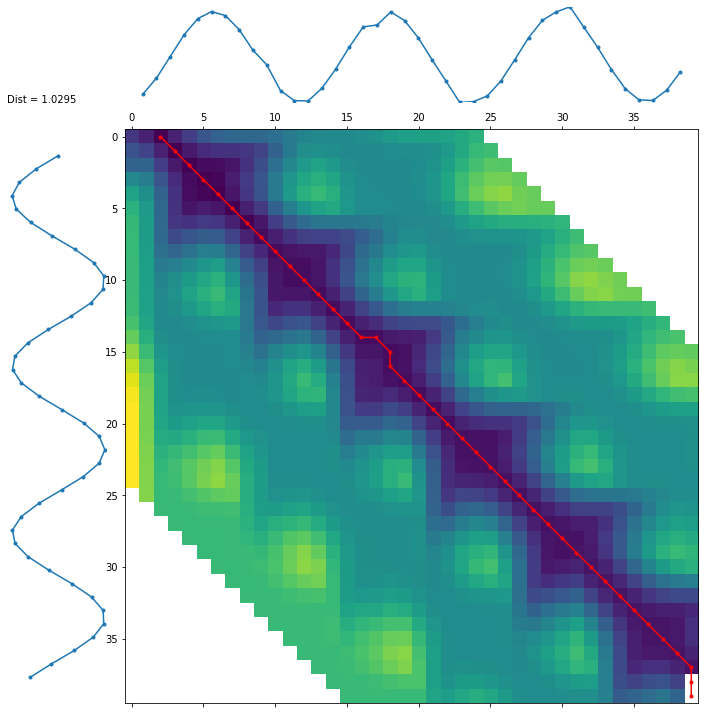

In [5]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np

x = np.arange(0, 20, .5)
s1 = np.sin(x)
s2 = np.sin(x - 1)
random.seed(1)

for idx in range(len(s2)):
    if random.random() < 0.05:
        s2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

## Hierarchical Clustering of time series

 - Create a sample of 6 time series
 - Use DTW to calculate distances
 - Then use hierarchical clustering to group most similar.

In [6]:
sample_ts = np.array([[0., 0., 1., 2., 1., 0., 1., 0., 0.,0., 0., 1., 2., 1., 0., 1., 0., 0.],
       [0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 2., 1., 0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 0., 1.],
       [1., 0., 1., 2., 0., 0., 4., 1., 0., 1., 0., 1., 2., 0., 0., 4., 1., 0.],
       [0., 1., 2., 0., 0., 2., 0., 1., 0., 0., 1., 2., 0., 0., 2., 0., 1., 0.],
       [0., 3., 1., 0., 1., 0., 4., 0., 0., 0., 3., 1., 0., 1., 0., 4., 0., 0.]])

In [7]:
from dtaidistance import clustering

# Custom Hierarchical clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = model1.fit(sample_ts)

# Keep track of full tree by using the HierarchicalTree wrapper class
model2 = clustering.HierarchicalTree(model1)
cluster_idx = model2.fit(sample_ts)

# You can also pass keyword arguments identical to instantiate a Hierarchical object
model2 = clustering.HierarchicalTree(dists_fun=dtw.distance_matrix_fast, dists_options={})
cluster_idx = model2.fit(sample_ts)

# SciPy linkage clustering
model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model3.fit(sample_ts)

DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
 83%|████████████████████████████████████████████████████████████████████▎             | 5/6 [00:00<00:00, 5006.33it/s]
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
 83%|████████████████████████████████████████████████████████████████████▎             | 5/6 [00:00<00:00, 5015.91it/s]
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
 83%|████████████████████████████████████████████████████████████████████▎             | 5/6 [00:00<00:00, 4846.67it/s]
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.


#### Visualize the hierarchy

In [8]:
model3.plot("hierarchyts.png")

(None, None)

<img src="hierarchyts.png">

## Kmeans clustering

K-means for time series requires an averaging strategy for time series. One possibility is DTW Barycenter Averaging. <br>
Paper: http://lig-membres.imag.fr/bisson/cours/M2INFO-AIW-ML/papers/PetitJean11.pdf <br>
Blog: https://blog.acolyer.org/2016/05/13/dynamic-time-warping-averaging-of-time-series-allows-faster-and-more-accurate-classification/

In [9]:
import dtaidistance
from dtaidistance.clustering import KMeans
from dtaidistance import dtw_barycenter
from dtaidistance.preprocessing import differencing
from scipy.io import arff
df = arff.loadarff("data/Trace_TRAIN.arff")

In [10]:
model = KMeans(k=4, max_it=10, max_dba_it=10, dists_options={"window": 40})
cluster_idx, performed_it = model.fit(sample_ts, use_c=True, use_parallel=False)


DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
  0%|                                                                                           | 0/10 [00:00<?, ?it/s]DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
 10%|████████▏   

In [11]:
# Return the cluster groupings
cluster_idx

{0: {4}, 1: {3}, 2: {0, 1, 2}, 3: {5}}

In [12]:
model.plot("dtwba_kmeans.png")

(None, None)

<img src="dtwba_kmeans.png">

## Fifty Words dataset

In [13]:
from scipy.io import arff
df = arff.loadarff("data/FiftyWords_TRAIN.arff")

In [14]:
words = pd.DataFrame(df[0])

In [15]:
words.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att262,att263,att264,att265,att266,att267,att268,att269,att270,target
0,-0.790419,-0.765171,-0.733542,-0.699633,-0.667740,-0.638633,-0.611808,-0.587282,-0.564301,-0.544381,...,-0.621745,-0.654709,-0.690325,-0.727638,-0.764249,-0.794860,-0.814730,-0.822708,-0.821335,b'9'
1,-0.764061,-0.744448,-0.743794,-0.720950,-0.717986,-0.702817,-0.691825,-0.680799,-0.671426,-0.683866,...,-0.453934,-0.365317,-0.311797,-0.336820,-0.429081,-0.534639,-0.629839,-0.711351,-0.774474,b'18'
2,-0.817041,-0.733105,-0.627820,-0.495715,-0.334888,-0.143279,0.077817,0.322732,0.586229,0.862018,...,-0.909609,-0.914889,-0.921817,-0.931149,-0.942135,-0.952195,-0.959054,-0.961743,-0.960863,b'1'
3,-1.103800,-1.071184,-1.024899,-0.967286,-0.905158,-0.844317,-0.783511,-0.720846,-0.658545,-0.592222,...,-0.974656,-1.000649,-1.031489,-1.064847,-1.095615,-1.119025,-1.132397,-1.135890,-1.132663,b'5'
4,-0.435999,-0.316359,-0.211705,-0.114854,-0.019499,0.070713,0.143294,0.193429,0.226835,0.251032,...,-0.163001,-0.264176,-0.348394,-0.408835,-0.446383,-0.475579,-0.516469,-0.579940,-0.650409,b'4'


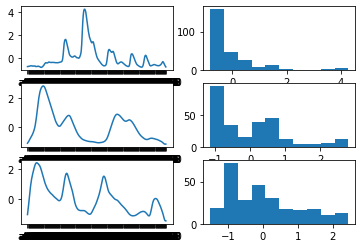

In [16]:

plt.subplot(3, 2, 1)
plt.plot(words.iloc[1, 1:-1])

plt.subplot(3, 2, 2)
plt.hist(words.iloc[1, 1:-1], 10)

plt.subplot(3, 2, 3)
plt.plot(words.iloc[3, 1:-1])

plt.subplot(3, 2, 4)
plt.hist(words.iloc[3, 1:-1], 10)

plt.subplot(3, 2, 5)
plt.plot(words.iloc[5, 1:-1])

plt.subplot(3, 2, 6)
plt.hist(words.iloc[5, 1:-1], 10)
plt.show()

In [17]:
from cesium import featurize

word_vals = words.iloc[:, 1:271]
times = []
word_values = []
for idx, row in word_vals.iterrows():
 word_values.append(row.values)
 times.append(np.array([i for i in range(row.values.shape[0])]))

features_to_use = ['amplitude','percent_beyond_1_std','percent_close_to_median']

featurized_words = featurize.featurize_time_series(times = times, values = word_values, errors = None,
                                                     features_to_use = features_to_use,scheduler = None)

In [18]:
featurized_words

feature,amplitude,percent_beyond_1_std,percent_close_to_median
channel,0,0,0
0,4.911354,0.107407,0.874074
1,9.407930,0.074074,0.918519
2,1.692392,0.188889,0.381481
3,3.067945,0.188889,0.388889
4,2.351115,0.129630,0.681481
...,...,...,...
445,2.409400,0.148148,0.670370
446,8.288659,0.151852,0.914815
447,1.940714,0.137037,0.307407


In [19]:
## create some features derived from histogram
times = []
hist_values = []
for idx, row in featurized_words.iterrows():
    hist_values.append(np.histogram(row.values,bins=10, range=(-2.5, 5.0))[0] + .0001)

## 0s cause downstream problems
times.append(np.array([i for i in range(9)]))
features_to_use = ["amplitude","percent_close_to_median","skew"]
featurized_hists = featurize.featurize_time_series(times = times,values = hist_values,
                    errors = None, features_to_use = features_to_use,
                    scheduler = None)

In [20]:
features = pd.concat([featurized_words.reset_index(drop=True),featurized_hists], axis=1)

In [21]:
from sklearn import preprocessing
feature_values = preprocessing.scale(features.values)

In [22]:
feature_values = np.nan_to_num(feature_values, nan=0)

In [23]:
from sklearn.cluster import AgglomerativeClustering
feature_clustering = AgglomerativeClustering(n_clusters = 50,linkage = 'ward')
feature_clustering.fit(feature_values)
words['feature_labels'] = feature_clustering.fit_predict(feature_values)

In [24]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(words.target, words.feature_labels)

0.6914229124920012